# Training the Network
### Saving to numpy array
For quick loading, it's helpful to save all the labels and images to a numpy array. This lets us easily load the arrays if we want to retrain the network on the same data. If we didn't do this, we would have to read every single image into an array every time we wanted to train. 

The first time you use a dataset after modifying it, set the bool below to True to save to an array. Then set it to false and you will just load the already saved array on your next use.

In [21]:
import numpy as np
import csv

In [22]:
from skimage import color
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm

In [23]:
# if true, re-reads and saves all images to numpy array
if False:
    labels = []

    with open("data/faceLabels.csv") as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        for row in reader:
            labels.append(row)
    labels = np.array(labels[1:])
    images = []
    size = (128,128)
    print("reading in images...")
    
    # tqdm is just creating a helpful loading bar. Functionally, it might as well read 'for line in labels:'
    for line in tqdm(labels):
        # read and convert to Black and White.
        img = io.imread('images/'+line[0], as_grey=True)
        # resize to fit the input to our model
        img = resize(img, size)
        images.append(img)
    print("saving...")
    
    # create empty numpy array to put all images into
    npimages = np.zeros(shape=(len(images),*size), dtype=np.float64)
    for i,im in enumerate(images):
        npimages[i] = im
    labels = np.array(labels[:,1],dtype=str)
    print(labels)
    np.save("data/labels.npy",labels)
    np.save("data/images.npy",npimages)
    print("SAVED")
    

In [32]:
#load arrays
images = np.load("data/images.npy")
labels = np.load("data/labels.npy")

### Checking images
show a random image and it's label just to sanity check our dataset.

		Sad


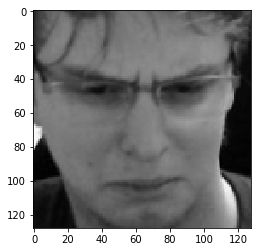

In [33]:
idx = np.random.randint(0,len(labels))
plt.imshow(images[idx], cmap="gray")
print("\t\t"+str(labels[idx]))

# Transform labels to integers
In order for the network to understand our labels, we need to one-hot-encode them. 
This means creating an array of zeros with a one representing our label.  
If we have 4 labels [Neutral, happy, Sad, Angry], then a happy label will look like this.  
[0,1,0,0]  
Since happy is the second index, we mark it with a 1.

The first step to one hot encoding is turning our labels into integers

In [60]:
from collections import Counter

#read labels and corisponding integers from csv file where we configured them.
intlabel = []
with open("data/labelList.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for row in reader:
        intlabel.append(row)

#put values into dicts for easy conversion
label2int = {y:int(x) for x,y in intlabel}
int2label = {int(x):y for x,y in intlabel}

#turn whole array of labels into integers
nplabels = np.array([label2int[x] for x in labels])
assert(len(nplabels) == len(images))

#count our labels to make sure they are relatively balanced and are being read correctly
count = Counter(labels)
print("count:",count.most_common())

count: [('Happy', 500), ('Sad', 500), ('Angry', 500), ('Neutral', 499)]


In [63]:
def one_hot(labels):
    #create a matrix big enough to store all our one hot encoded labels
    y = np.zeros([len(labels),max(labels)+1],dtype=int)
    y[np.arange(len(labels)),labels] = 1
    return y

# Split training and testing datasets

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train, x_val, y_train, y_val = train_test_split(images, nplabels, test_size=.1)
y_train = one_hot(y_train)
y_val = one_hot(y_val)
print("number of validation samples:",str(len(y_val)))

number of validation samples: 200


# Build Model

In [19]:
import tensorflow as tf
from Expression_Network import Expression_Network

In [20]:
num_classes = len(count.most_common())

exnet = Expression_Network(num_classes,Training=True).build_model()
exnet.build(input_shape=(None,128,128))
exnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 120, 32)      2624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        247872    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0

In [15]:
exnet.compile("Adam","categorical_crossentropy",metrics=['accuracy'])

tb_callback= tf.keras.callbacks.TensorBoard(log_dir="data")

In [16]:
#exnet.fit_generator(next_batch(x_train,y_train,64),steps_per_epoch=1,epochs=1)
exnet.fit(x_train,y_train, validation_data=(x_val,y_val),steps_per_epoch=None,epochs=200,verbose=2,callbacks=[tb_callback])

Train on 1799 samples, validate on 200 samples
Epoch 1/200
1799/1799 - 3s - loss: 1.7998 - accuracy: 0.4186 - val_loss: 1.7723 - val_accuracy: 0.3950
Epoch 2/200
1799/1799 - 1s - loss: 0.9388 - accuracy: 0.8038 - val_loss: 1.6529 - val_accuracy: 0.8650
Epoch 3/200
1799/1799 - 1s - loss: 0.6058 - accuracy: 0.9266 - val_loss: 1.6038 - val_accuracy: 0.5100
Epoch 4/200
1799/1799 - 1s - loss: 0.5148 - accuracy: 0.9461 - val_loss: 1.6055 - val_accuracy: 0.6800
Epoch 5/200
1799/1799 - 1s - loss: 0.4307 - accuracy: 0.9666 - val_loss: 1.3300 - val_accuracy: 0.8650
Epoch 6/200
1799/1799 - 1s - loss: 0.3423 - accuracy: 0.9867 - val_loss: 1.2393 - val_accuracy: 0.8850
Epoch 7/200
1799/1799 - 1s - loss: 0.3062 - accuracy: 0.9867 - val_loss: 0.8636 - val_accuracy: 0.8400
Epoch 8/200
1799/1799 - 1s - loss: 0.2858 - accuracy: 0.9861 - val_loss: 0.5717 - val_accuracy: 0.9400
Epoch 9/200
1799/1799 - 1s - loss: 0.2703 - accuracy: 0.9850 - val_loss: 0.5933 - val_accuracy: 0.8800
Epoch 10/200
1799/1799 - 1

Epoch 80/200
1799/1799 - 1s - loss: 0.0553 - accuracy: 0.9900 - val_loss: 0.7229 - val_accuracy: 0.8700
Epoch 81/200
1799/1799 - 1s - loss: 0.0770 - accuracy: 0.9883 - val_loss: 0.8129 - val_accuracy: 0.8450
Epoch 82/200
1799/1799 - 1s - loss: 0.0844 - accuracy: 0.9839 - val_loss: 0.3119 - val_accuracy: 0.9500
Epoch 83/200
1799/1799 - 1s - loss: 0.0595 - accuracy: 0.9944 - val_loss: 0.1571 - val_accuracy: 0.9650
Epoch 84/200
1799/1799 - 1s - loss: 0.0482 - accuracy: 0.9994 - val_loss: 0.1502 - val_accuracy: 0.9750
Epoch 85/200
1799/1799 - 1s - loss: 0.0417 - accuracy: 0.9978 - val_loss: 0.1680 - val_accuracy: 0.9650
Epoch 86/200
1799/1799 - 1s - loss: 0.0388 - accuracy: 0.9983 - val_loss: 0.1044 - val_accuracy: 0.9750
Epoch 87/200
1799/1799 - 1s - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.1884 - val_accuracy: 0.9650
Epoch 88/200
1799/1799 - 1s - loss: 0.0689 - accuracy: 0.9883 - val_loss: 0.3815 - val_accuracy: 0.9550
Epoch 89/200
1799/1799 - 1s - loss: 0.0679 - accuracy: 0.9911 - 

KeyboardInterrupt: 

In [17]:
#exnet.save_weights("checkpoints/model.h5")
exnet.save_weights("checkpoints/model.h5")